We are changing the version of the numba package to make sure it works with the ydata_profiling package.

In [1]:
!pip install numba==0.58.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 33.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 MB 21.1 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully uninstalled numba-0.60.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.10.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.1 which is incompatible.


In [2]:
import numpy  as np 
import pandas as pd 

from itertools import product
from ydata_profiling import ProfileReport

from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics         import make_scorer, roc_auc_score, fbeta_score, accuracy_score
from sklearn.ensemble        import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree            import DecisionTreeClassifier

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn           as sns

import time
from datetime import timedelta

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/udacity-mlcharity-competition/census.csv
/kaggle/input/udacity-mlcharity-competition/example_submission.csv
/kaggle/input/udacity-mlcharity-competition/test_census.csv


We are loading the training data from Census.

In [3]:
data = pd.read_csv('/kaggle/input/udacity-mlcharity-competition/census.csv')
data.head(5)

age          workclass education_level  education-num       marital-status  \
0   39          State-gov       Bachelors           13.0        Never-married   
1   50   Self-emp-not-inc       Bachelors           13.0   Married-civ-spouse   
2   38            Private         HS-grad            9.0             Divorced   
3   53            Private            11th            7.0   Married-civ-spouse   
4   28            Private       Bachelors           13.0   Married-civ-spouse   

           occupation    relationship    race      sex  capital-gain  \
0        Adm-clerical   Not-in-family   White     Male        2174.0   
1     Exec-managerial         Husband   White     Male           0.0   
2   Handlers-cleaners   Not-in-family   White     Male           0.0   
3   Handlers-cleaners         Husband   Black     Male           0.0   
4      Prof-specialty            Wife   Black   Female           0.0   

   capital-loss  hours-per-week  native-country income  
0           0.0            40.0   United-States  <=50K  
1           0.0            13.0   United-States  <=50K  
2           0.0            40.0   United-States  <=50K  
3           0.0            40.0   United-States  <=50K  
4           0.0            40.0            Cuba  <=50K

# Data Exploration

In [4]:
report = ProfileReport(data,title="Continuous variables")
report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

From the above analysis we can observe the following:
- education-num and education_level are highly correlated,
- capital-gain and capital-loss are strongly skewed with the vast majority being 0 (this makes sense since it represent an uncommon scenario for most people)

Let's now look at the distribution of age across several features.

First let's look at the distribution of income by age. As expected, those making more than $50K tend to be older individuals.

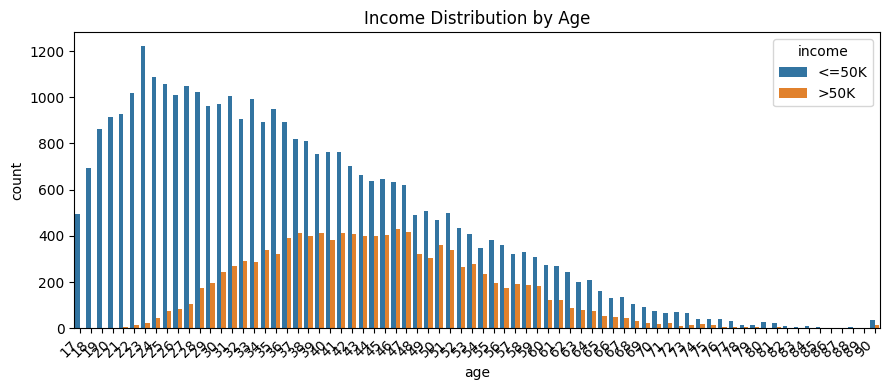

In [5]:
fig, ax = plt.subplots(figsize=(9,4))
sns.countplot(x=data['age'],hue=data['income'],ax=ax)
ax.set_title('Income Distribution by Age')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right')
fig.tight_layout();

Then, let's look at the income distribution by job type. We can see that most jobs paying over $50K are in the private sector.

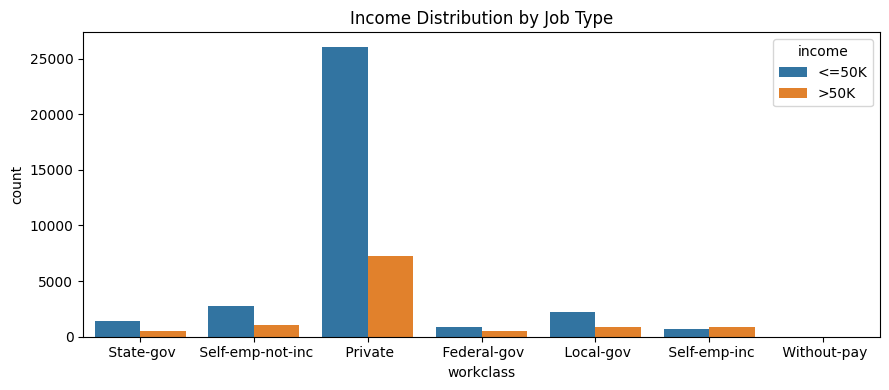

In [6]:
fig, ax = plt.subplots(figsize=(9,4))
sns.countplot(x=data['workclass'],hue=data['income'],ax=ax)
ax.set_title('Income Distribution by Job Type')
fig.tight_layout();

We can also look at the Occupation type, and some obvious suspects stand out.

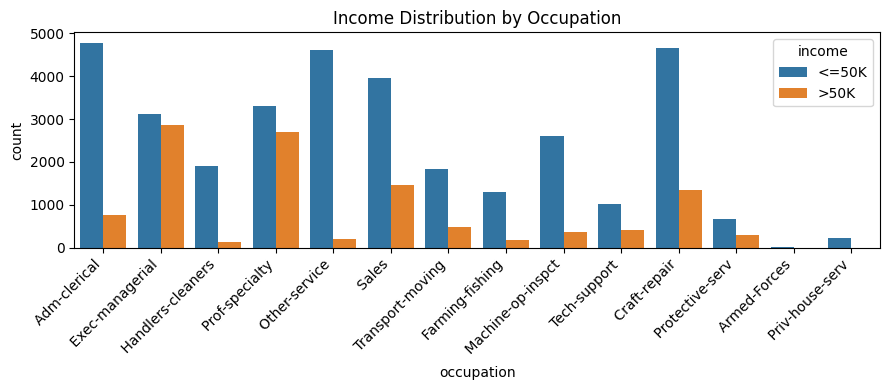

In [7]:
fig, ax = plt.subplots(figsize=(9,4))
sns.countplot(x=data['occupation'],hue=data['income'],ax=ax)
ax.set_title('Income Distribution by Occupation')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right')
fig.tight_layout();

Next we have education level. As expected, higher education brackets show the highest number of high earners.

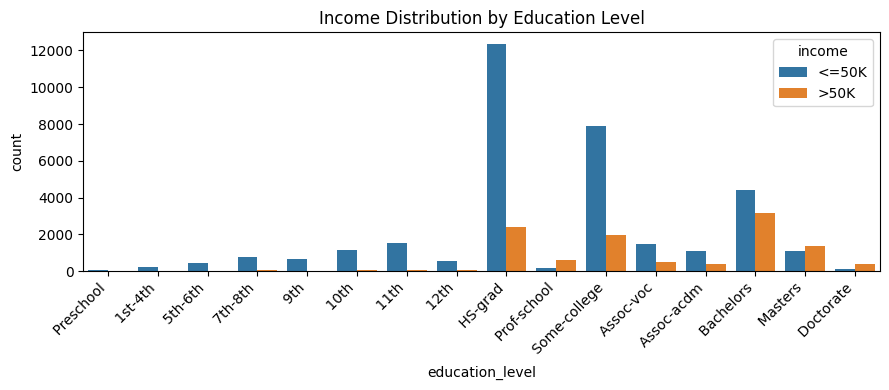

In [8]:
_edu = [' Preschool',' 1st-4th',' 5th-6th',' 7th-8th',' 9th',' 10th',' 11th',' 12th',' HS-grad',' Prof-school',' Some-college',' Assoc-voc',' Assoc-acdm', ' Bachelors',' Masters',' Doctorate'  ]
_edu = data.sort_values('education_level',key=lambda s: s.apply(_edu.index),ignore_index=True)

fig, ax = plt.subplots(figsize=(9,4))
sns.countplot(x=_edu['education_level'],hue=_edu['income'],ax=ax)
ax.set_title('Income Distribution by Education Level')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right')
fig.tight_layout();

From the Marital status we can observe that individuals who are married are likely to pull a double income.

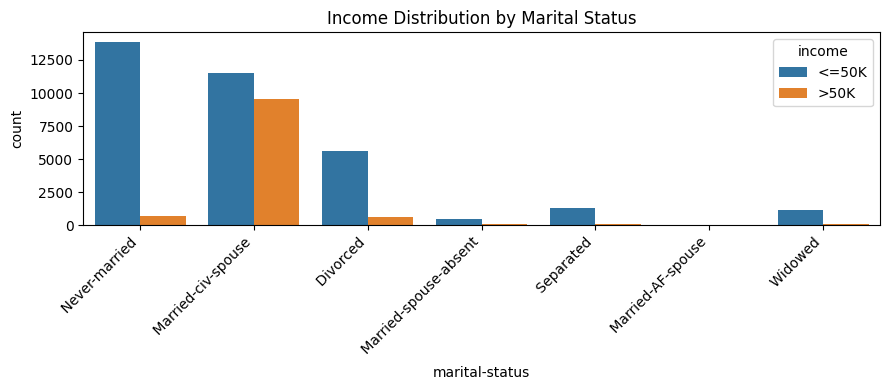

In [9]:
fig, ax = plt.subplots(figsize=(9,4))
sns.countplot(x=data['marital-status'],hue=data['income'],ax=ax)
ax.set_title('Income Distribution by Marital Status')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right')
fig.tight_layout();

This is very similar to the distribution for Relationship status.

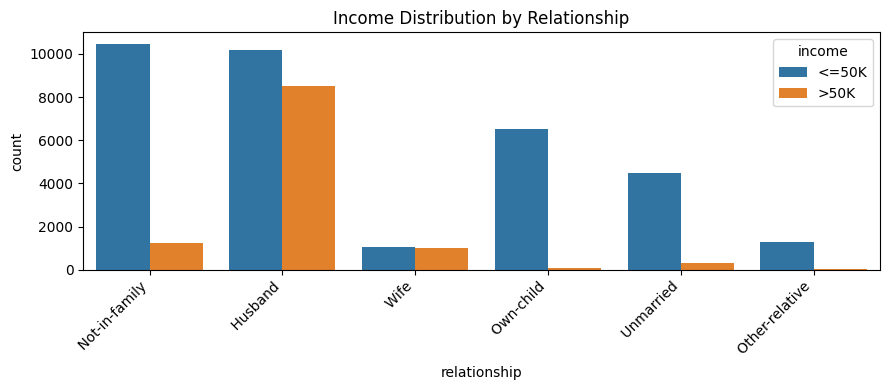

In [10]:
fig, ax = plt.subplots(figsize=(9,4))
sns.countplot(x=data['relationship'],hue=data['income'],ax=ax)
ax.set_title('Income Distribution by Relationship')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right')
fig.tight_layout();

The next category, race, might indicated further investigation on the country of origin is necessary.

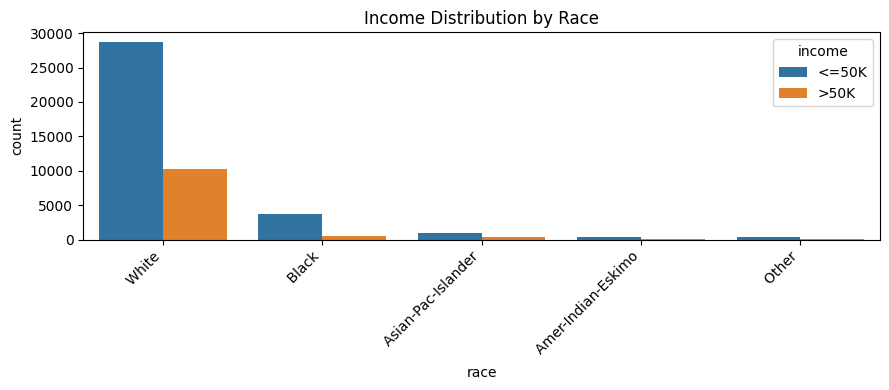

In [11]:
fig, ax = plt.subplots(figsize=(9,4))
sns.countplot(x=data['race'],hue=data['income'],ax=ax)
ax.set_title('Income Distribution by Race')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right')
fig.tight_layout();

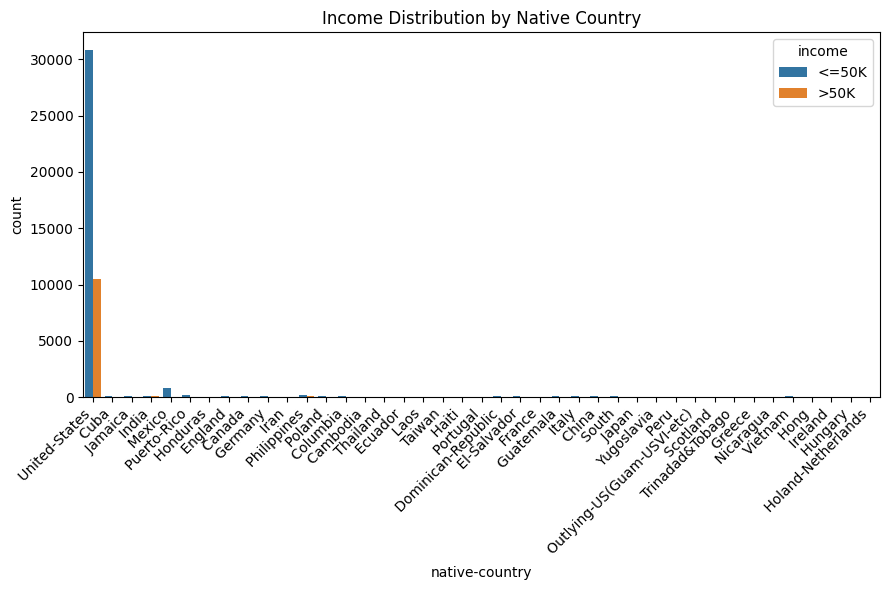

In [12]:
fig, ax = plt.subplots(figsize=(9,6))
sns.countplot(x=data['native-country'],hue=data['income'],ax=ax)
ax.set_title('Income Distribution by Native Country')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right')
fig.tight_layout();

Unfortunately, not surprisingly we see a pay gap between male and female individuals.

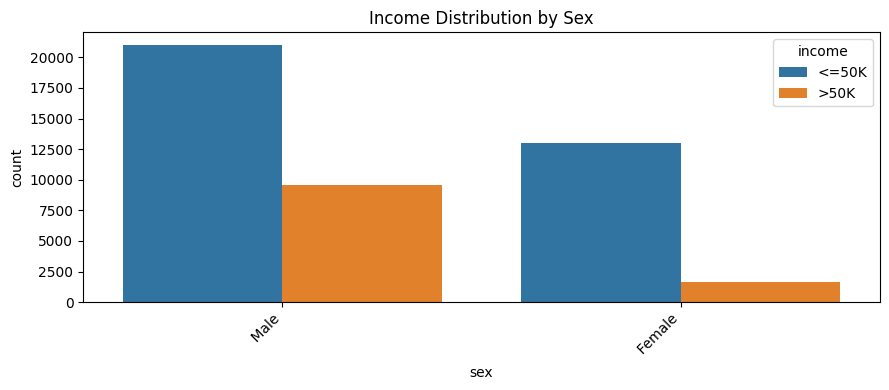

In [13]:
fig, ax = plt.subplots(figsize=(9,4))
sns.countplot(x=data['sex'],hue=data['income'],ax=ax)
ax.set_title('Income Distribution by Sex')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right')
fig.tight_layout();

Looking at hours worked per week, we can see that the majority of people are at the 40 hours mark, with people doing overtime having the potential to earn more.

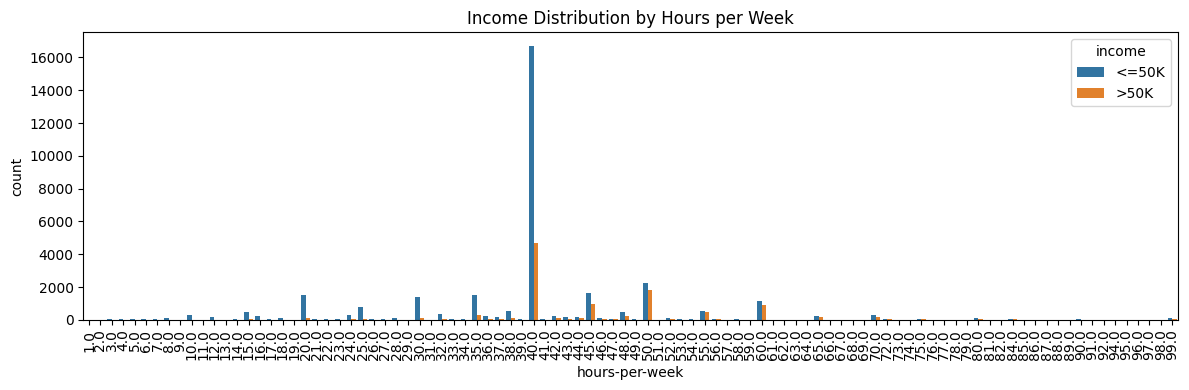

In [14]:
fig, ax = plt.subplots(figsize=(12,4))
sns.countplot(x=data['hours-per-week'],hue=data['income'],ax=ax)
ax.set_title('Income Distribution by Hours per Week')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
fig.tight_layout();

Now, we are splitting and processing the income as our target variable.

In [15]:
income = data['income'].apply(lambda x: 1 if x=='>50K' else 0)
data.drop('income',axis=1,inplace=True)

We divide our features in continuous and categorical.

In [16]:
_continuous  = ['age','capital-gain','capital-loss','hours-per-week']
_categorical = ['workclass','education_level','marital-status','occupation','relationship','race','sex','native-country']

Here we apply the logarithm transformation to the highly skewed features.

In [17]:
data[['capital-gain','capital-loss']] = data[['capital-gain','capital-loss']].apply(lambda x: np.log(x + 1))

And we are normalizing the continuous features.

In [18]:
data[_continuous] = MinMaxScaler().fit_transform(data[_continuous])

Finally, we hot encode the categorical features.

In [19]:
data = pd.get_dummies(data)

From looking at the correlation of the features we can see that they are generally low correlated. This is also true in terms of our target variable.

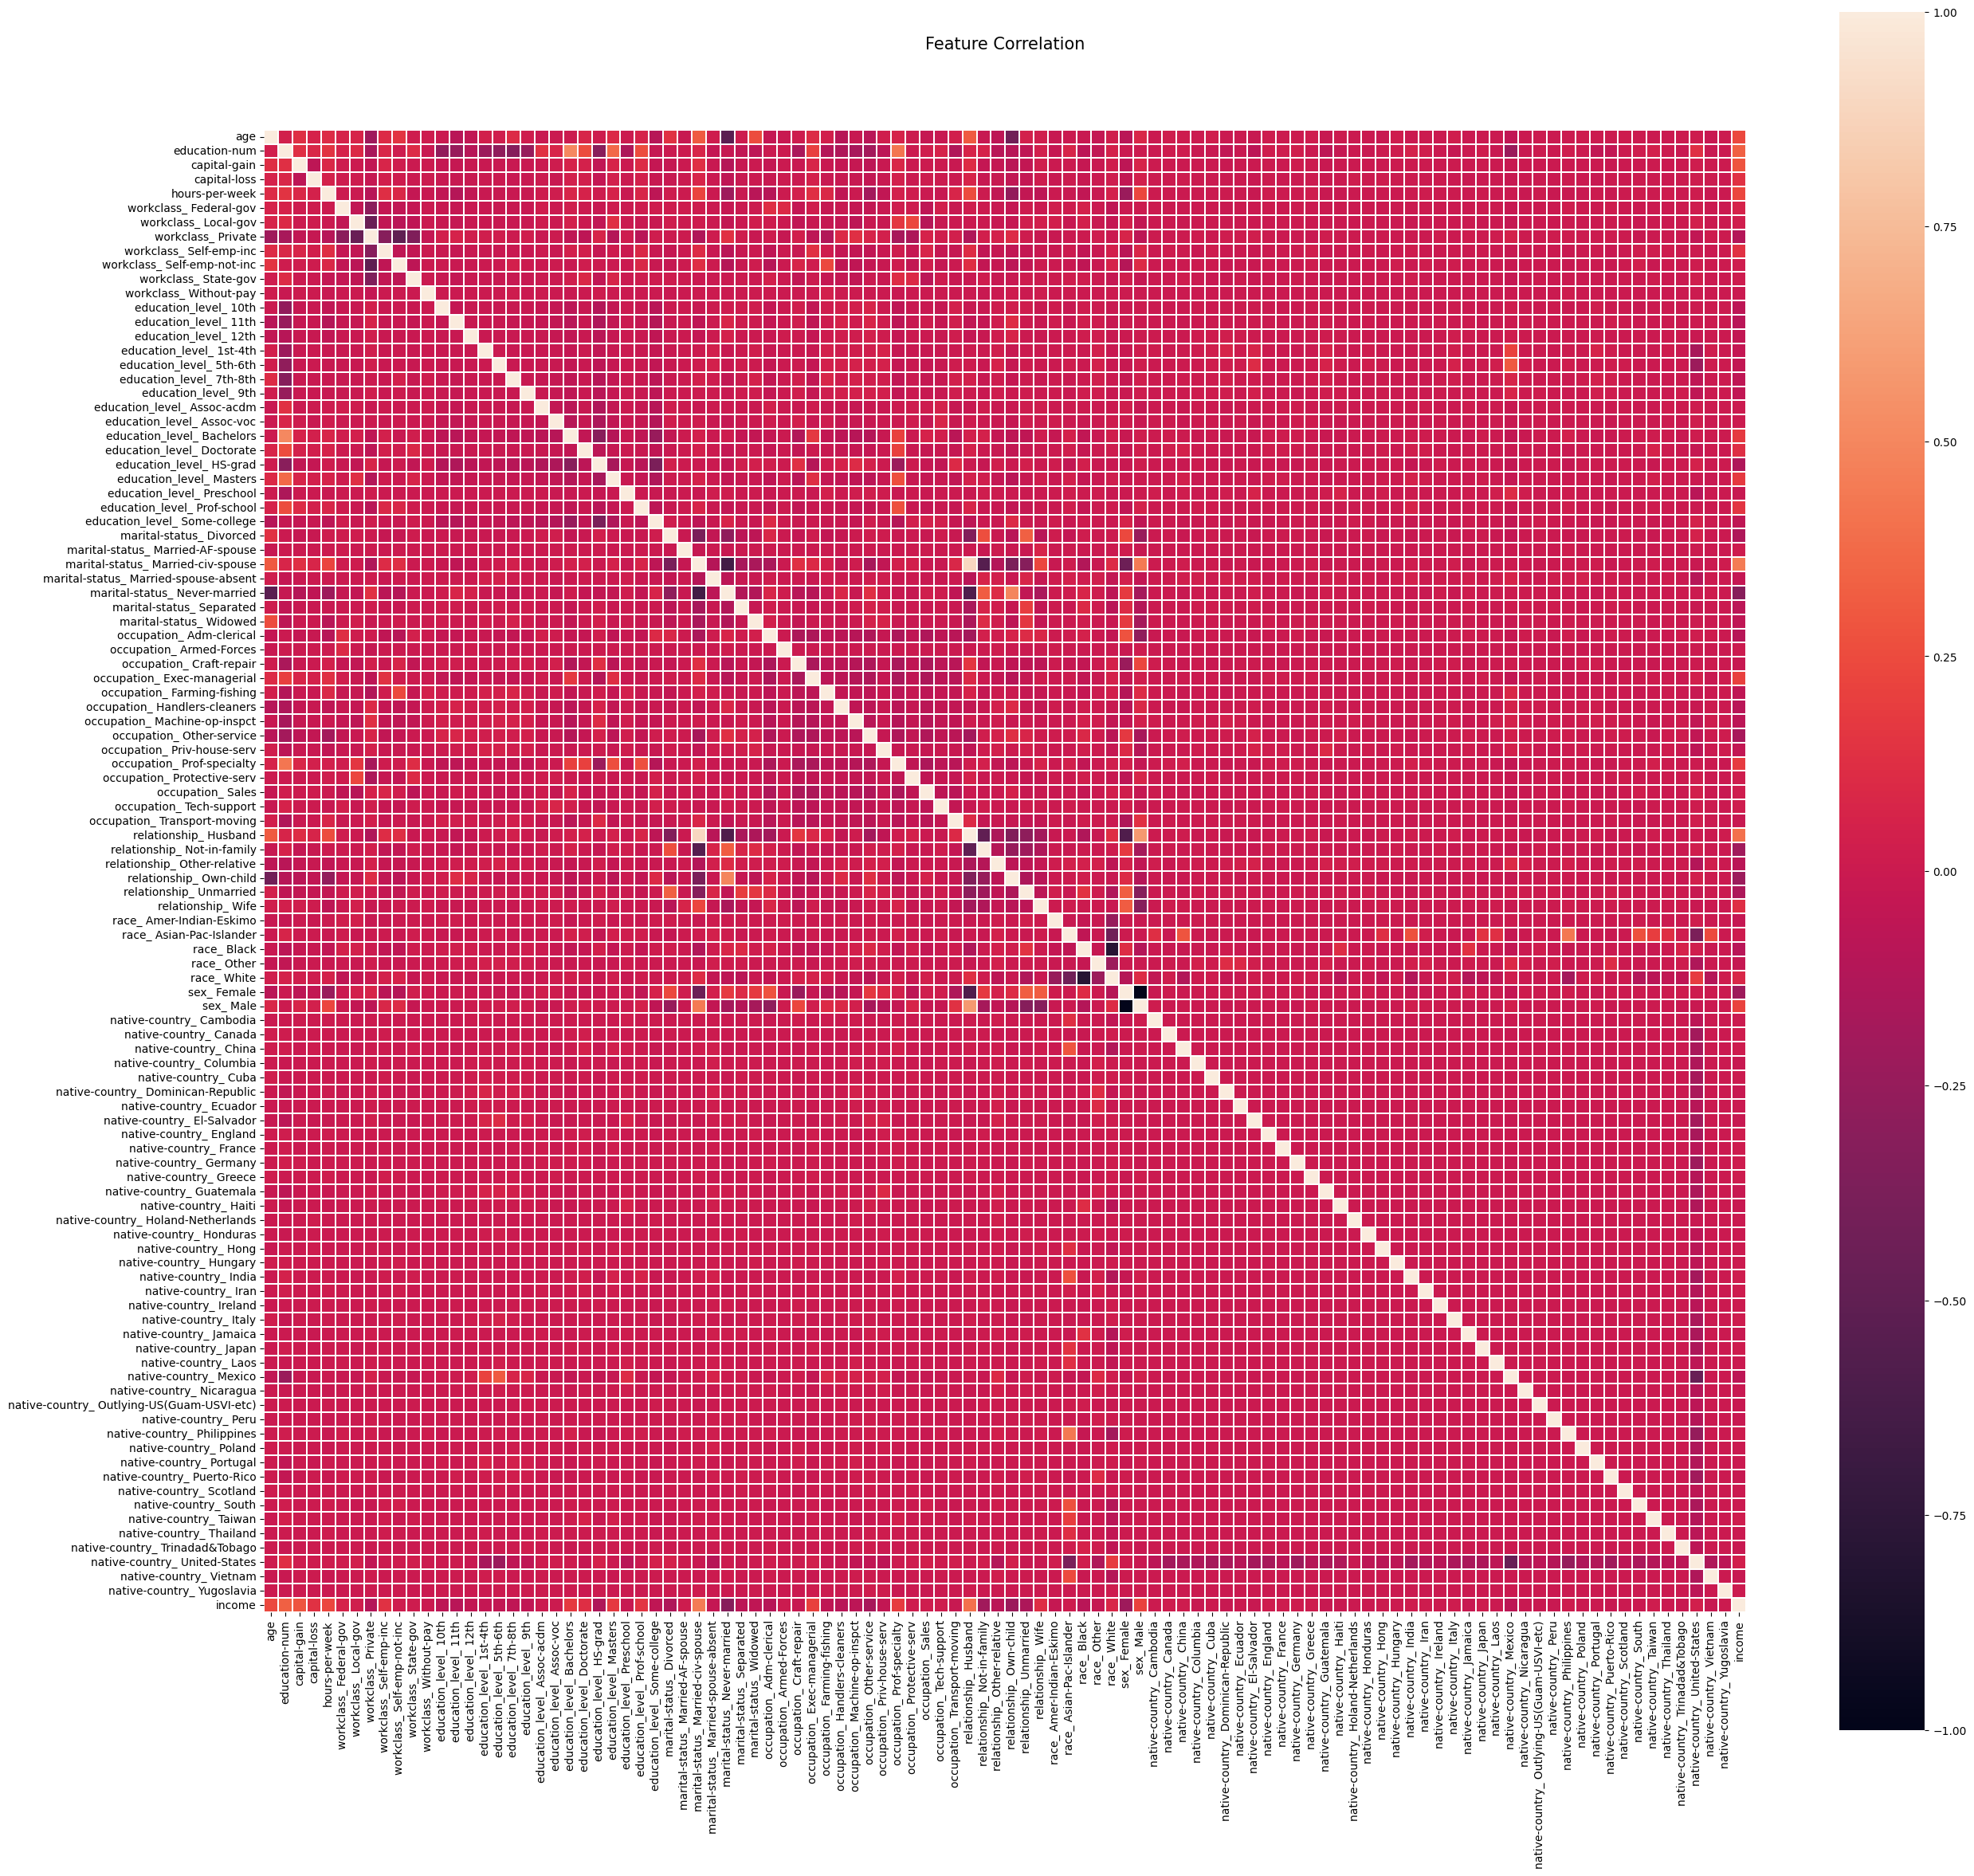

In [20]:
plt.figure(figsize=(30,28))
plt.title('Feature Correlation', y=1.05, size=15)
sns.heatmap(pd.concat([data,income],axis=1).corr(),linewidths=0.1,vmax=1.0,square=True,linecolor='white');

# Splitting data into train and test

In [21]:
data_train, data_val, income_train, income_val = train_test_split(data,income,test_size=0.2,random_state=123)
print("Training set has {} samples.".format(data_train.shape[0]))
print("Validation set has {} samples.".format(data_val.shape[0]))

Training set has 36177 samples.
Validation set has 9045 samples.


# Modeling

### AdaBoost
The first model we explore is AdaBoost.

In [22]:
model = AdaBoostClassifier(random_state=123)

We are creating a search space to tune the hyperparameters

In [23]:
estimators = [DecisionTreeClassifier(splitter='random',max_features='sqrt',max_depth=x,min_samples_leaf=y,random_state=123) for x, y in product([3,4,5,6],[2,5,10,25])]
parameters = {'estimator':estimators,
              'n_estimators':[50,100,150,200,250,300],
              'learning_rate':[0.25,0.35,0.50,0.65,0.75,1]}
scorer = make_scorer(roc_auc_score,average='weighted')
grid = GridSearchCV(model,param_grid=parameters,scoring=scorer,n_jobs=-1,verbose=3)

In [24]:
_start = time.time()
models = grid.fit(data_train,income_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV 3/5] END estimator=DecisionTreeClassifier(max_depth=3, max_features='sqrt', min_samples_leaf=2,
                       random_state=123, splitter='random'), learning_rate=0.25, n_estimators=50;, score=0.761 total time=   1.9s
[CV 2/5] END estimator=DecisionTreeClassifier(max_depth=3, max_features='sqrt', min_samples_leaf=2,
                       random_state=123, splitter='random'), learning_rate=0.25, n_estimators=100;, score=0.767 total time=   3.8s
[CV 1/5] END estimator=DecisionTreeClassifier(max_depth=3, max_features='sqrt', min_samples_leaf=2,
                       random_state=123, splitter='random'), learning_rate=0.25, n_estimators=150;, score=0.774 total time=   5.7s
[CV 5/5] END estimator=DecisionTreeClassifier(max_depth=3, max_features='sqrt', min_samples_leaf=2,
                       random_state=123, splitter='random'), learning_rate=0.25, n_estimators=150;, score=0.773 total time=   6.1s
[CV 4/5] END 

In [25]:
_end = time.time()
print('Total search time: {}'.format(str(timedelta(seconds=_end-_start))))

Total search time: 1:29:14.630513


Note: I've separately searched a different hyperparamether space with more complex estimators, however that search space had considerable higher resource cost and didn't provide much improvement. That is not to say that in a real world scenario, with better resources, we shouldn't explore more complex model, but given the scope of this project, I will not continue tuning these hyperparameters.

In [26]:
scores = pd.concat([pd.DataFrame(models.cv_results_['params']),pd.DataFrame(models.cv_results_['mean_test_score'],columns=['AUC'])],axis=1)
scores = scores.sort_values('AUC',ascending=False)
scores.head(5)

estimator  learning_rate  \
83   DecisionTreeClassifier(max_depth=3, max_featur...           0.35   
119  DecisionTreeClassifier(max_depth=3, max_featur...           0.35   
113  DecisionTreeClassifier(max_depth=3, max_featur...           0.25   
131  DecisionTreeClassifier(max_depth=3, max_featur...           0.65   
137  DecisionTreeClassifier(max_depth=3, max_featur...           0.75   

     n_estimators       AUC  
83            300  0.783427  
119           300  0.782670  
113           300  0.782205  
131           300  0.782173  
137           300  0.782138

To finalize the search for this model, we will test the top 5 best performing models on the validation set.

In [27]:
for i in range(5):
    print('Model #: {}'.format(i+1))
    print('Estimator: ',scores.loc[scores.index[i]]['estimator'])
    print('Learning Rate: ',scores.loc[scores.index[i]]['learning_rate'])
    print('N Estimators: ',scores.loc[scores.index[i]]['n_estimators'])
    ada = AdaBoostClassifier(estimator=scores.loc[scores.index[i]]['estimator'],n_estimators=scores.loc[scores.index[i]]['n_estimators'],learning_rate=scores.loc[scores.index[i]]['learning_rate'],random_state=123)
    ada = ada.fit(data_train,income_train)

    ada_pred_train       = ada.predict(data_train)
    ada_pred_train_probs = ada.predict_proba(data_train)[:,1]
    
    ada_pred_val       = ada.predict(data_val)
    ada_pred_val_probs = ada.predict_proba(data_val)[:,1]

    print('In sample performance:     AUC: {}   |   F-Score: {}   |   Accuracy: {}'.format(round(roc_auc_score(income_train,ada_pred_train_probs),6),round(fbeta_score(income_train,ada_pred_train,beta=0.5),6),round(accuracy_score(income_train,ada_pred_train),6)))
    print('Out of sample performance: AUC: {}   |   F-Score: {}   |   Accuracy: {}'.format(round(roc_auc_score(income_val,ada_pred_val_probs),6),round(fbeta_score(income_val,ada_pred_val,beta=0.5),6),round(accuracy_score(income_val,ada_pred_val),6)))
    print()
    print()

Model #: 1
Estimator:  DecisionTreeClassifier(max_depth=3, max_features='sqrt', min_samples_leaf=10,
                       random_state=123, splitter='random')
Learning Rate:  0.35
N Estimators:  300
In sample performance:     AUC: 0.922998   |   F-Score: 0.734525   |   Accuracy: 0.861487
Out of sample performance: AUC: 0.907845   |   F-Score: 0.709867   |   Accuracy: 0.854726


Model #: 2
Estimator:  DecisionTreeClassifier(max_depth=3, max_features='sqrt', min_samples_leaf=25,
                       random_state=123, splitter='random')
Learning Rate:  0.35
N Estimators:  300
In sample performance:     AUC: 0.921232   |   F-Score: 0.731319   |   Accuracy: 0.859994
Out of sample performance: AUC: 0.910885   |   F-Score: 0.710665   |   Accuracy: 0.854947


Model #: 3
Estimator:  DecisionTreeClassifier(max_depth=3, max_features='sqrt', min_samples_leaf=25,
                       random_state=123, splitter='random')
Learning Rate:  0.25
N Estimators:  300
In sample performance:     AUC: 0

From the above we see that the best model on the out of sample portion of the data is Model #3 with the following parameters:
- Estimator: DecisionTreeClassifier(max_depth=3, max_features='sqrt', min_samples_leaf=25, random_state=123, splitter='random')
- Learning Rate: 0.25
- N of Estimators: 300

The out of sample AUC for this model is: 0.911468.

### XGBoost
The second model we explore is XGBoost. We will follow the same process as for the AdaBoost.

In [28]:
model = XGBClassifier() # tree_method='hist',early_stopping_rounds=5
parameters = {'n_estimators':[200,250,300],
              'max_depth':[3,5,7],
              'min_child_weight':[3,5,10,25],
              'learning_rate':[0.01,0.1,0.25],
              'subsample':[0.8,1],
              'colsample_bytree':[0.6,0.8,1],
              'gamma': [0.01,0.1,0.2]}
scorer = make_scorer(roc_auc_score)
grid = GridSearchCV(model,param_grid=parameters,scoring=scorer,n_jobs=-1,verbose=3)

In [29]:
_start = time.time()
models = grid.fit(data_train,income_train)

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits
[CV 5/5] END estimator=DecisionTreeClassifier(max_depth=6, max_features='sqrt', min_samples_leaf=25,
                       random_state=123, splitter='random'), learning_rate=0.65, n_estimators=200;, score=0.773 total time=   9.3s
[CV 4/5] END estimator=DecisionTreeClassifier(max_depth=6, max_features='sqrt', min_samples_leaf=25,
                       random_state=123, splitter='random'), learning_rate=0.65, n_estimators=250;, score=0.784 total time=  11.9s
[CV 3/5] END estimator=DecisionTreeClassifier(max_depth=6, max_features='sqrt', min_samples_leaf=25,
                       random_state=123, splitter='random'), learning_rate=0.65, n_estimators=300;, score=0.779 total time=  14.3s
[CV 3/5] END estimator=DecisionTreeClassifier(max_depth=6, max_features='sqrt', min_samples_leaf=25,
                       random_state=123, splitter='random'), learning_rate=0.75, n_estimators=50;, score=0.776 total time=   2.4s
[CV 5/5]

In [30]:
_end = time.time()
print('Total search time: {}'.format(str(timedelta(seconds=_end-_start))))

Total search time: 2:23:33.801589


In [31]:
scores = pd.concat([pd.DataFrame(models.cv_results_['params']),pd.DataFrame(models.cv_results_['mean_test_score'],columns=['AUC'])],axis=1)
scores = scores.sort_values('AUC',ascending=False)
scores.head(5)

colsample_bytree  gamma  learning_rate  max_depth  min_child_weight  \
370                0.6   0.10           0.25          3                 5   
368                0.6   0.10           0.25          3                 5   
584                0.6   0.20           0.25          3                 5   
1444               1.0   0.01           0.25          3                 3   
152                0.6   0.01           0.25          3                 5   

      n_estimators  subsample       AUC  
370            300        0.8  0.803199  
368            250        0.8  0.802976  
584            250        0.8  0.802923  
1444           300        0.8  0.802607  
152            250        0.8  0.802590

In [40]:
for i in range(5):
    print('Model #: {}'.format(i+1))
    print('N Estimators: ',scores.loc[scores.index[i]]['n_estimators'])
    print('Learning Rate: ',scores.loc[scores.index[i]]['learning_rate'])
    print('Max Depth: ',scores.loc[scores.index[i]]['max_depth'])
    print('Min Child Weight: ',scores.loc[scores.index[i]]['min_child_weight'])
    print('Subsample: ',scores.loc[scores.index[i]]['subsample'])
    print('Col Sample By Tree: ',scores.loc[scores.index[i]]['colsample_bytree'])
    print('Gamma: ',scores.loc[scores.index[i]]['gamma'])
    xgb = XGBClassifier(n_estimators=int(scores.loc[scores.index[i]]['n_estimators']),
                        learning_rate=scores.loc[scores.index[i]]['learning_rate'],
                        max_depth=int(scores.loc[scores.index[i]]['max_depth']),
                        min_child_weight=int(scores.loc[scores.index[i]]['min_child_weight']),
                        subsample=scores.loc[scores.index[i]]['subsample'],
                        colsample_bytree=scores.loc[scores.index[i]]['colsample_bytree'],
                        gamma=scores.loc[scores.index[i]]['gamma'],
                        random_state=123)
    xgb = xgb.fit(data_train,income_train)

    xgb_pred_train       = xgb.predict(data_train)
    xgb_pred_train_probs = xgb.predict_proba(data_train)[:,1]
    
    xgb_pred_val       = xgb.predict(data_val)
    xgb_pred_val_probs = xgb.predict_proba(data_val)[:,1]

    print('In sample performance:     AUC: {}   |   F-Score: {}   |   Accuracy: {}'.format(round(roc_auc_score(income_train,xgb_pred_train_probs),6),round(fbeta_score(income_train,xgb_pred_train,beta=0.5),6),round(accuracy_score(income_train,xgb_pred_train),6)))
    print('Out of sample performance: AUC: {}   |   F-Score: {}   |   Accuracy: {}'.format(round(roc_auc_score(income_val,xgb_pred_val_probs),6),round(fbeta_score(income_val,xgb_pred_val,beta=0.5),6),round(accuracy_score(income_val,xgb_pred_val),6)))
    print()
    print()

Model #: 1
N Estimators:  300.0
Learning Rate:  0.25
Max Depth:  3.0
Min Child Weight:  5.0
Subsample:  0.8
Col Sample By Tree:  0.6
Gamma:  0.1
In sample performance:     AUC: 0.937144   |   F-Score: 0.775297   |   Accuracy: 0.878707
Out of sample performance: AUC: 0.925624   |   F-Score: 0.746323   |   Accuracy: 0.869762


Model #: 2
N Estimators:  250.0
Learning Rate:  0.25
Max Depth:  3.0
Min Child Weight:  5.0
Subsample:  0.8
Col Sample By Tree:  0.6
Gamma:  0.1
In sample performance:     AUC: 0.936035   |   F-Score: 0.771139   |   Accuracy: 0.877215
Out of sample performance: AUC: 0.925736   |   F-Score: 0.742249   |   Accuracy: 0.867993


Model #: 3
N Estimators:  250.0
Learning Rate:  0.25
Max Depth:  3.0
Min Child Weight:  5.0
Subsample:  0.8
Col Sample By Tree:  0.6
Gamma:  0.2
In sample performance:     AUC: 0.936335   |   F-Score: 0.772292   |   Accuracy: 0.877519
Out of sample performance: AUC: 0.925951   |   F-Score: 0.741858   |   Accuracy: 0.867993


Model #: 4
N Estima

From the above we see that the best model (while pretty similar to the others) on the out of sample portion of the data is Model #3 with the following parameters:
- N of Estimators: 250
- Learning Rate: 0.25
- Max Depth: 3
- Min Child Weight: 5
- Subsample: 0.8
- Col Sample By Tree: 0.6
- Gamma: 0.2

The out of sample AUC for this model is: 0.925951

# Blended Model
Now that we have established the best hyperparameters for our two models, we will create a blended version and compare performance.

In [54]:
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,max_features='sqrt',min_samples_leaf=25,splitter='random',random_state=123),n_estimators=300,learning_rate=0.25,random_state=123)
ada = ada.fit(data_train,income_train)
ada_probs = ada.predict_proba(data_val)[:,1]
ada_preds = [1 if p>=0.5 else 0 for p in ada_probs]

In [55]:
xgb = XGBClassifier(n_estimators=250,learning_rate=0.25,max_depth=3,min_child_weight=5,subsample=0.8,colsample_bytree=0.6,gamma=0.2,random_state=123)
xgb = xgb.fit(data_train,income_train)
xgb_probs = xgb.predict_proba(data_val)[:,1]
xgb_preds = [1 if p>=0.5 else 0 for p in xgb_probs]

In [56]:
blend_probs = (ada_proba+xgb_proba)/2
blend_preds = [1 if p>=0.5 else 0 for p in blend_probs]

In [57]:
print('AdaBoost performance: AUC: {}   |   F-Score: {}   |   Accuracy: {}'.format(round(roc_auc_score(income_val,ada_probs),6),round(fbeta_score(income_val,ada_preds,beta=0.5),6),round(accuracy_score(income_val,ada_preds),6)))
print('XGBoost performance:  AUC: {}   |   F-Score: {}   |   Accuracy: {}'.format(round(roc_auc_score(income_val,xgb_probs),6),round(fbeta_score(income_val,xgb_preds,beta=0.5),6),round(accuracy_score(income_val,xgb_preds),6)))
print('Blended performance:  AUC: {}   |   F-Score: {}   |   Accuracy: {}'.format(round(roc_auc_score(income_val,blend_probs),6),round(fbeta_score(income_val,blend_preds,beta=0.5),6),round(accuracy_score(income_val,blend_preds),6)))

AdaBoost performance: AUC: 0.911468   |   F-Score: 0.712211   |   Accuracy: 0.8555
XGBoost performance:  AUC: 0.925951   |   F-Score: 0.741858   |   Accuracy: 0.867993
Blended performance:  AUC: 0.925765   |   F-Score: 0.742997   |   Accuracy: 0.868436


The AUC of the blended model is slightly lower than that of the XGB but it shows higher F-Score and Accuracy. We will submit both the XGB and the blended model.

# Preparing data for submission

In [71]:
data_train_raw = pd.read_csv('/kaggle/input/udacity-mlcharity-competition/census.csv')
data_test   = pd.read_csv('/kaggle/input/udacity-mlcharity-competition/test_census.csv')
submission = data_test[['Unnamed: 0']].copy()
submission.rename(columns={submission.columns[0]:'id'},inplace=True)
data_test.drop(['Unnamed: 0'],axis=1,inplace=True)

In [72]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              45205 non-null  float64
 1   workclass        45200 non-null  object 
 2   education_level  45202 non-null  object 
 3   education-num    45208 non-null  float64
 4   marital-status   45201 non-null  object 
 5   occupation       45200 non-null  object 
 6   relationship     45206 non-null  object 
 7   race             45203 non-null  object 
 8   sex              45203 non-null  object 
 9   capital-gain     45207 non-null  float64
 10  capital-loss     45205 non-null  float64
 11  hours-per-week   45209 non-null  float64
 12  native-country   45206 non-null  object 
dtypes: float64(5), object(8)
memory usage: 4.5+ MB


In [73]:
data_test.isnull().sum()

age                17
workclass          22
education_level    20
education-num      14
marital-status     21
occupation         22
relationship       16
race               19
sex                19
capital-gain       15
capital-loss       17
hours-per-week     13
native-country     16
dtype: int64

We can see we have some null values in this file so we need to fill them in. 
For the continuous values we will use the mean. However, for the highly skewed ones we will use the median. Finally, for the categorical values we will use the most frequent value.

In [74]:
for c in ['age','hours-per-week','education-num']:
    data_test[c]= data_test[c].fillna(data_train_raw[c].mean())

for c in ['capital-gain','capital-loss']:
    data_test[c]= data_test[c].fillna(data_train_raw[c].median())

for c in _categorical:
    data_test[c]= data_test[c].fillna(data_train_raw.groupby([c])[c].count().sort_values(ascending=False).index[0])

In [75]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              45222 non-null  float64
 1   workclass        45222 non-null  object 
 2   education_level  45222 non-null  object 
 3   education-num    45222 non-null  float64
 4   marital-status   45222 non-null  object 
 5   occupation       45222 non-null  object 
 6   relationship     45222 non-null  object 
 7   race             45222 non-null  object 
 8   sex              45222 non-null  object 
 9   capital-gain     45222 non-null  float64
 10  capital-loss     45222 non-null  float64
 11  hours-per-week   45222 non-null  float64
 12  native-country   45222 non-null  object 
dtypes: float64(5), object(8)
memory usage: 4.5+ MB


Then, we will apply the same transformations as the training data.

In [76]:
data_test[['capital-gain','capital-loss']] = data_test[['capital-gain','capital-loss']].apply(lambda x: np.log(x+1))
data_test[_continuous] = MinMaxScaler().fit_transform(data_test[_continuous])
data_test = pd.get_dummies(data_test,dtype='int')

And now we are ready to make our predictions.

In [86]:
ada_probs = ada.predict_proba(data_test)[:,1]
xgb_probs = ada.predict_proba(data_test)[:,1]
blend_probs = (ada_probs+xgb_probs)/2

In [90]:
submission_xgb = submission.copy()
submission_xgb['income'] = xgb_probs
submission_xgb.to_csv('submission_xgb.csv',index=False)

In [88]:
submission_blended = submission.copy()
submission_blended['income'] = blend_probs
submission_blended.to_csv('submission_blended.csv',index=False)

The public scores for the two submissions are:
- XGBoost: 0.91763
- Blended: 0.91763

